In [1]:
import modin.pandas as pd #built on top of dask with parallelization and hookers
import os
import numpy as np
from datetime import datetime

np.random.seed(123)

# Functions

In [2]:
def parse_date(date_str):
    yr,mon,day = [int(val) for val in date_str.split('-')]
    return datetime (yr,mon,day)


def make_invoice_map(invoice_number,p=0.2):
    """
    Selects invoices for a random sample
    """
    invoice_map = {}
    for val in invoice_number:
        if val not in invoice_map:
            invoice_map[val] = bool(np.random.binomial(p=p,n=1))
    return invoice_map

# Random Sample Creation

We will chose random invoices rather than random rows to preserve the structure of particular invoices

In [3]:
DATA_PATH = os.path.join("..","data","raw")
PROCESSED_DATA_PATH = os.path.join("..","data","processed")

In [4]:
os.listdir(DATA_PATH)

['data_1.csv',
 'data_10.csv',
 'data_11.csv',
 'data_12.csv',
 'data_13.csv',
 'data_14.csv',
 'data_15.csv',
 'data_16.csv',
 'data_17.csv',
 'data_18.csv',
 'data_19.csv',
 'data_2.csv',
 'data_3.csv',
 'data_4.csv',
 'data_5.csv',
 'data_6.csv',
 'data_7.csv',
 'data_8.csv',
 'data_9.csv']

In [5]:
data = pd.concat([pd.read_csv(os.path.join(DATA_PATH,file),usecols=['invoice_and_item_number']) 
                  for file in os.listdir(DATA_PATH)])

3) it seems like the key value consists of two parts:

* invoice number (one letter and 6 numbers)
* item number (five nummbers)
Let's split it. It will allow us to join different items into a set contained in the same invoice.
Now we can make a correct random sample including random invoices

In [6]:
data['invoice_number'] = data.invoice_and_item_number.apply(lambda x: x[:7])
data['invoice_letter'] = data.invoice_and_item_number.apply(lambda x: x[0])

In [7]:
data.head()

,invoice_and_item_number,invoice_number,invoice_letter
0,S03731700008,S037317,S
1,S13410800085,S134108,S
2,S05600200038,S056002,S
3,S06944000033,S069440,S
4,S26729300053,S267293,S


In [8]:
data.invoice_letter.fillna('NA').value_counts()

To request implementation, send an email to feature_requests@modin.org.


S    9881372
I    8216755
3        184
4        106
dtype: int64

In [9]:
data.invoice_letter.value_counts() / data.invoice_letter.count()

S    0.545980
I    0.454004
3    0.000010
4    0.000006
dtype: float64

We have 290 rows with strange invoice numbers. We shoud check them.

It seems like we have splitted the invoice_and_item_number correctly. We have only 14_000 of invoices with one item which is expected.

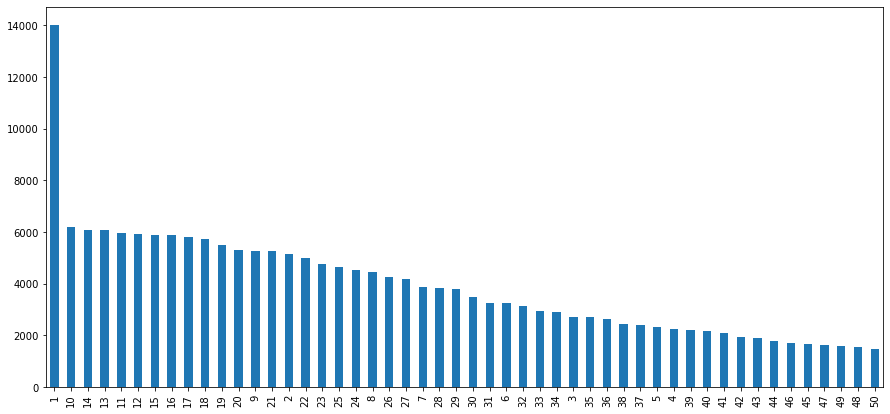

In [22]:
data.groupby('invoice_number').invoice_number.count().value_counts().head(50).plot.bar(figsize=(15,7))

In [23]:
data.groupby('invoice_number').invoice_number.count().describe()

count    255128.000000
mean         70.938576
std        1022.100609
min           1.000000
25%          13.000000
50%          25.000000
75%          48.000000
max       43374.000000
Name: invoice_number, dtype: float64

# Part 1. Choosing random invoices

In [10]:
unique_invoices = data.invoice_number.groupby(data.invoice_number).count().index.values

In [11]:
chosen_invoices = set(np.random.choice(unique_invoices,size=int(unique_invoices.shape[0]*0.2),replace=False))

In [12]:
bad_invoices = set((data[data['invoice_letter'].apply(lambda x: x not in ('S','I'))].invoice_number.drop_duplicates().values))

In [13]:
bad_invoices

{'3068313', '3789000', '3818000', '3818001', '4295S05', '4697000'}

In [14]:
df_columns = ['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons']


In [15]:
sample = pd.DataFrame([])
bad_invoices_data = pd.DataFrame([])
for file in os.listdir(DATA_PATH):
    tmp = pd.read_csv(os.path.join(DATA_PATH,file),parse_dates=['date'],date_parser=parse_date) 
    tmp['invoice_number'] = tmp.invoice_and_item_number.apply(lambda x: x[:7])       
    tmp['to_sample'] = tmp.invoice_number.apply(lambda x: x in chosen_invoices)
    tmp['bad_invoice'] = tmp.invoice_number.apply(lambda x: x in bad_invoices)
    
    sample = sample.append(tmp[tmp.to_sample]) if sample.shape[0] else tmp[tmp.to_sample]
    bad_invoices_data = bad_invoices_data.append(tmp[tmp.bad_invoice]) if sample.shape[0] else tmp[tmp.bad_invoice]
    
    print(sample.shape, tmp.to_sample.sum())

(203947, 27) 203947
(408463, 27) 204516
(610888, 27) 202425
(814647, 27) 203759
(1017912, 27) 203265
(1222584, 27) 204672
(1426530, 27) 203946
(1630841, 27) 204311
(1835302, 27) 204461
(2039521, 27) 204219
(2059458, 27) 19937
(2263159, 27) 203701
(2468205, 27) 205046
(2671164, 27) 202959
(2875569, 27) 204405
(3079039, 27) 203470
(3283492, 27) 204453
(3487741, 27) 204249
(3691388, 27) 203647


In [18]:
tmp = None
data = None
unique_invoices = None

In [14]:
sample.agg({'invoice_and_item_number':'count'
            ,'date':['min','max','nunique']
            ,'pack':['mean','std']
            ,'volume_sold_liters':['mean','std']})

,invoice_and_item_number,date,pack,volume_sold_liters
count,3691388.0,NaN,NaN,NaN
max,NaN,2020-02-28 00:00:00,NaN,NaN
mean,NaN,NaN,12.302063,9.140501
min,NaN,2012-01-03 00:00:00,NaN,NaN
nunique,NaN,1304,NaN,NaN
std,NaN,NaN,7.633034,32.954753


In [20]:
sample.to_csv(os.path.join(PROCESSED_DATA_PATH,"sample.csv")) 

In [23]:
bad_invoices_data.iloc[10]

invoice_and_item_number                               469700030
date                                        2012-07-12 00:00:00
store_number                                               4697
store_name                 Southside Liquor & Tobacco / Iowa Ci
address                                      601 HOLLYWOOD BLVD
city                                                  IOWA CITY
zip_code                                                  52240
store_location                      POINT (-91.52741 41.643807)
county_number                                                52
county                                                  Johnson
category                                             1.0813e+06
category_name                               PEPPERMINT SCHNAPPS
vendor_number                                               434
vendor_name                                      Luxco-St Louis
item_number                                               80571
item_description                 Arrow P